In [1]:
import os
import json
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Lambda
from transformers import TFViTModel, ViTImageProcessor
import keras

In [2]:
drive_folder = '/content/drive/MyDrive/Colab Notebooks/Masters/BigDataAnalysisProject/models/'
drive.mount('/content/drive')

Mounted at /content/drive


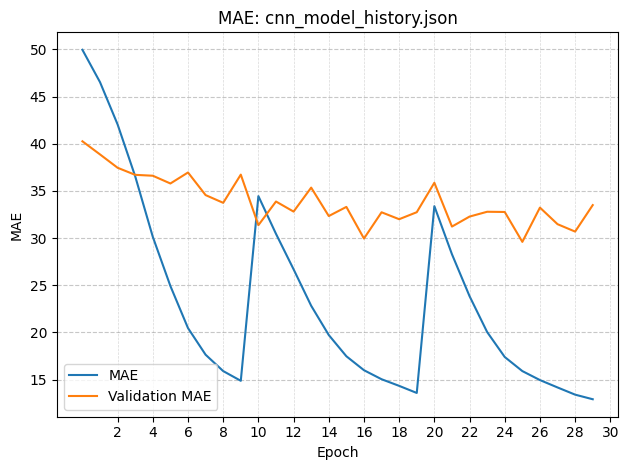

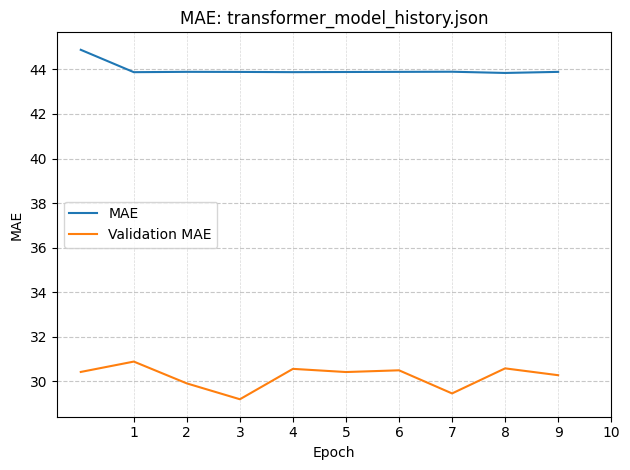

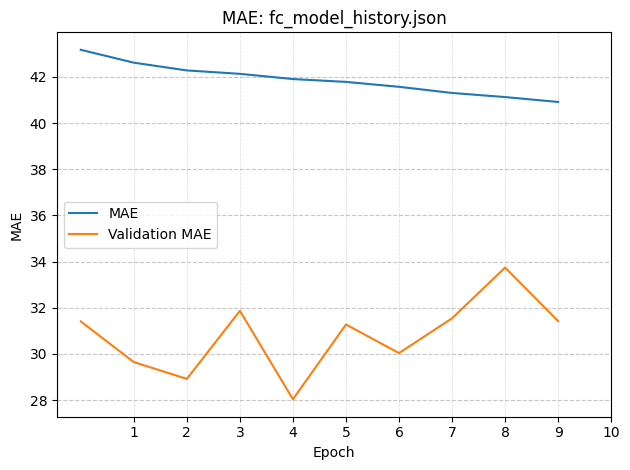

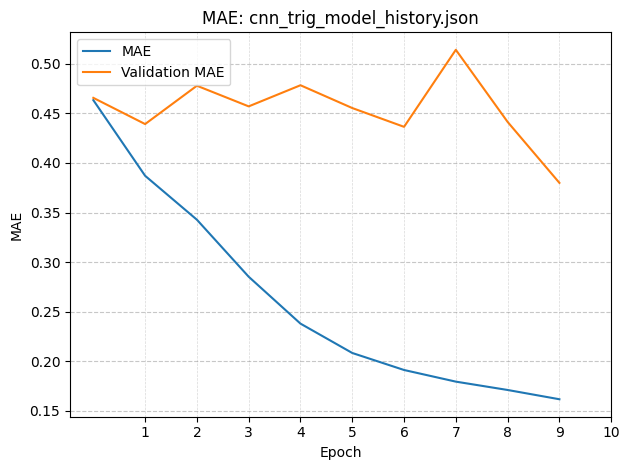

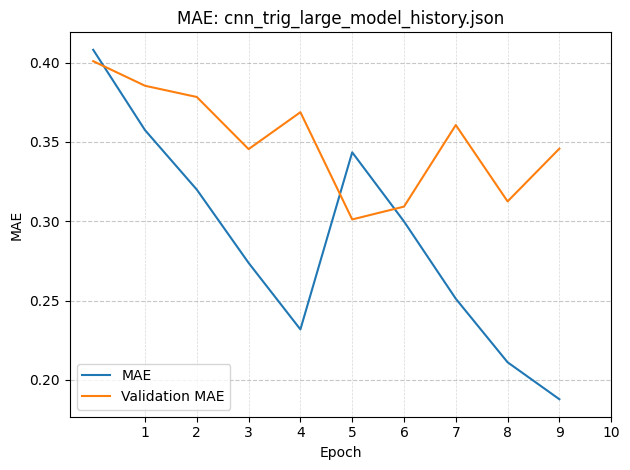

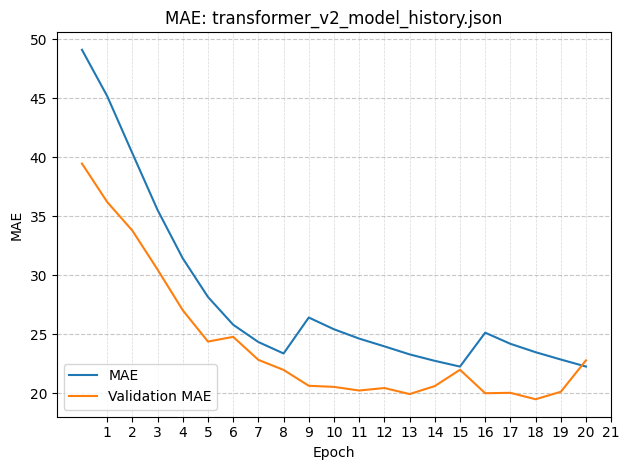

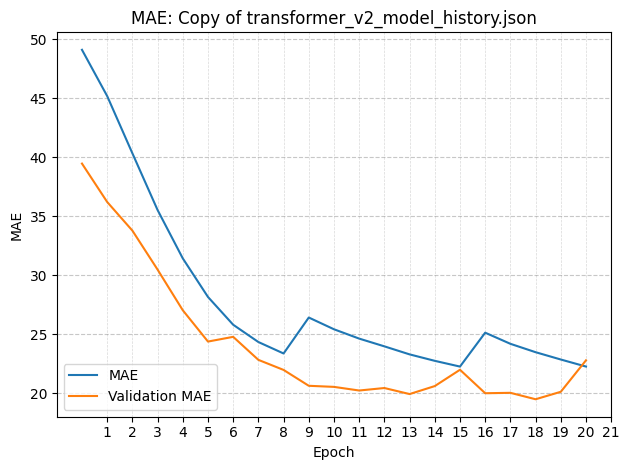

In [22]:
# Get all JSON file paths in the folder
json_files = [f for f in os.listdir(drive_folder) if f.endswith('.json')]

# Loop through and plot each JSON history
for i, json_file in enumerate(json_files):
    json_path = os.path.join(drive_folder, json_file)

    with open(json_path, 'r') as f:
        history = json.load(f)

    epochs = list(range(1, len(history['loss']) + 1))
    if i == 0:
      epochs = [x for x in epochs if x % 2 == 0]

    # Horizontal Lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot training and validation MAE
    plt.subplot(1, 1, 1)
    plt.plot(history['mae'], label='MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.title(f'MAE: {json_file}')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.xticks(epochs)
    plt.legend()

    # Vertical lines
    for epoch in epochs:
        plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [4]:
keras.config.enable_unsafe_deserialization() # allow cv model to load
model_name = 'transformer_v2_temp_model.keras' # Change this to change model loaded

In [5]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/Masters/BigDataAnalysisProject/osv5m/processed/test/'
df_test = pd.read_pickle(f'{test_dir}00.pkl')

In [8]:
X_test_image = np.stack(df_test["image"].values)
X_test_time_date = df_test[["time", "year_percent"]].to_numpy().astype(np.float32)

y_test = df_test[['latitude', 'longitude']].values.astype(np.float32)

results_df = df_test[['country', 'latitude', 'longitude']]

In [9]:
import tensorflow as tf

In [ ]:
@register_keras_serializable()
class TransposeCHW(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.transpose(inputs, perm=[0, 3, 1, 2])

@register_keras_serializable()
class ViTPoolerOutput(tf.keras.layers.Layer):
    def __init__(self, model_name="google/vit-base-patch16-224-in21k", **kwargs):
        super().__init__(**kwargs)
        self.model_name = model_name
        from transformers import TFViTModel
        self.vit = TFViTModel.from_pretrained(self.model_name)
        self.vit.trainable = True

    def call(self, inputs):
        return self.vit({"pixel_values": inputs}).pooler_output

    def get_config(self):
        config = super().get_config()
        config.update({
            "model_name": self.model_name
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

model_path = "/content/drive/MyDrive/Colab Notebooks/Masters/BigDataAnalysisProject/models/transformer_v2_model.keras"
history_path = "/content/drive/MyDrive/Colab Notebooks/Masters/BigDataAnalysisProject/models/transformer_v2_model_history.json"

if os.path.exists(model_path):
    print("Loading existing model...")
    model = tf.keras.models.load_model(model_path)
    with open(history_path, "r") as f:
      old_history = json.load(f)
else:
    print("Fail")

In [ ]:
# Example prediction
preds = model.predict({"image_input": X_test_image, "time_date": X_test_time_date}, verbose=0)
print(results_df.head(3))
print(preds[:3])

In [ ]:
# Load each model and make predictions on test data and concatenate predictions into table
model_files = [f for f in os.listdir(drive_folder) if f.endswith(".keras") or os.path.isdir(os.path.join(drive_folder, f))]

final_df = results_df.copy()

for model_file in model_files:
    model_path = os.path.join(drive_folder, model_file)
    try:
        model = tf.keras.models.load_model(model_path, custom_objects={'vit_preprocess': vit_preprocess})

        preds = model.predict({"image_input": X_train_image, "time_date": X_train_time_date}, verbose=0)
        if (preds.shape[1] == 2):
          result_df = pd.DataFrame(preds, columns=[f"pred_lat_{model_file[:-6]}", f"pred_lon_{model_file[:-6]}"])
          final_df = pd.concat([final_df, result_df], axis=1)
          print(result_df.head(2))
          print(final_df.head(2))
        if (preds.shape[1] == 3):
          lat_scaled = preds[:, 0]
          long_cos = preds[:, 1]
          long_sin = preds[:, 2]
          lat = lat_scaled * 90.0
          long_rad = np.arctan2(long_sin, long_cos)
          long_d = np.degrees(long_rad)
          preds_new = np.stack([lat, long_d], axis=1)

          result_df = pd.DataFrame(preds_new, columns=[f"pred_lat_{model_file[:-6]}", f"pred_lon_{model_file[:-6]}"])
          final_df = pd.concat([final_df, result_df], axis=1)
          print(result_df.head(2))
          print(final_df.head(2))
    except:
        continue

In [ ]:
final_df.head(3)

,country,latitude,longitude,pred_lat_cnn_model,pred_lon_cnn_model,pred_lat_fc_model,pred_lon_fc_model,pred_lat_cnn_trig_model,pred_lon_cnn_trig_model,pred_lat_cnn_trig_large_model,pred_lon_cnn_trig_large_model
0,IT,37.956651,14.954485,31.251257,93.487022,25.284939,-7.766946,18.886814,15.895043,37.164551,-5.045401
1,ML,12.373333,-8.909906,39.609108,-81.528038,28.687643,-31.473989,24.463362,-14.408059,36.217491,-54.890434
2,TH,7.510295,99.061884,20.269423,92.160774,15.719324,36.695602,9.720903,60.771938,-14.627466,-44.684151
